# Group 2D cells in 3D
This script loads all bounding boxes for a given slice, clusters them in 3D, and derives meaningful 3D bounding boxes (frustums), where each frustum represents a cell in 3D.

In [1]:
# Import required packages and set configs
import os
import glob
import json
import torch
import numpy as np
import seaborn as sns
from tqdm import tqdm
from PIL import Image, ImageDraw
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
# Configs
output_dir = "output/ClusteredPredictionsPlots"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Load the data
images_dir = "data/slices/half/all_slices2_done_predictions/"
anns_dir = os.path.join(images_dir, "annotations")
images_list = sorted(glob.glob(images_dir + "/*.png"))
anns_list = sorted(glob.glob(anns_dir + "/*.json"))
print(f"Detected {len(images_list)} images.\nDetected {len(anns_list)} annotation files.")
print(images_list)
print(anns_list)

Detected 21 images.
Detected 21 annotation files.
['data/slices/half/all_slices2_done_predictions/0.png', 'data/slices/half/all_slices2_done_predictions/1.png', 'data/slices/half/all_slices2_done_predictions/10.png', 'data/slices/half/all_slices2_done_predictions/11.png', 'data/slices/half/all_slices2_done_predictions/12.png', 'data/slices/half/all_slices2_done_predictions/13.png', 'data/slices/half/all_slices2_done_predictions/14.png', 'data/slices/half/all_slices2_done_predictions/15.png', 'data/slices/half/all_slices2_done_predictions/16.png', 'data/slices/half/all_slices2_done_predictions/17.png', 'data/slices/half/all_slices2_done_predictions/18.png', 'data/slices/half/all_slices2_done_predictions/19.png', 'data/slices/half/all_slices2_done_predictions/2.png', 'data/slices/half/all_slices2_done_predictions/20.png', 'data/slices/half/all_slices2_done_predictions/3.png', 'data/slices/half/all_slices2_done_predictions/4.png', 'data/slices/half/all_slices2_done_predictions/5.png', 'da

In [4]:
# Collect the bounding boxes along with their z values
bbox_list = []

# Loop through all bounding boxes
for anns_path in tqdm(anns_list):
    # Load the annotations file
    with open(anns_path, 'rb') as f:
        anns = json.load(f)

    # Extract the z-value
    z = float(anns_path.split('/')[-1].split('.')[0])
    
    # Build the bounding box information
    for label in anns['shapes']:
        points = label['points']
        bbox_info = {
            "x1": min(points[0][0], points[1][0]), # x min
            "x2": max(points[0][0], points[1][0]), # x max
            "y1": min(points[0][1], points[1][1]), # y min
            "y2": max(points[0][1], points[1][1]), # y max
            "z": z,
            "annotations_file": anns_path,
        }

        # Append to the list of bounding boxes
        bbox_list.append(bbox_info)

print(f"Extracted {len(bbox_list)} bounding boxes in total")


100%|██████████| 21/21 [00:00<00:00, 2337.84it/s]

Extracted 1505 bounding boxes in total


In [5]:
# IoU calculation function. 
# Adopted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] <= bb1['x2'], f"{bb1['x1']}, {bb1['x2']}"
    assert bb1['y1'] <= bb1['y2'], f"{bb1['y1']}, {bb1['y2']}"
    assert bb2['x1'] <= bb2['x2'], f"{bb2['x1']}, {bb2['x2']}"
    assert bb2['y1'] <= bb2['y2'], f"{bb2['y1']}, {bb2['y2']}"

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [6]:
# Compute the IoU distances between all pairs of bounding boxes [len(bbox_list) x len(bbox_list)]
n_boxes = len(bbox_list)
iou_matrix = torch.empty(size=(n_boxes, n_boxes))
for i in tqdm(range(n_boxes)):
    for j in range(n_boxes):
        iou_score = get_iou(bbox_list[i], bbox_list[j])
        iou_matrix[i][j] = iou_score
print("Creating the adjacency matrix")
adjacency_matrix = np.array(iou_matrix)

100%|██████████| 1505/1505 [00:18<00:00, 79.47it/s]

Creating the adjacency matrix


/tmp/ipykernel_8331/1558638206.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


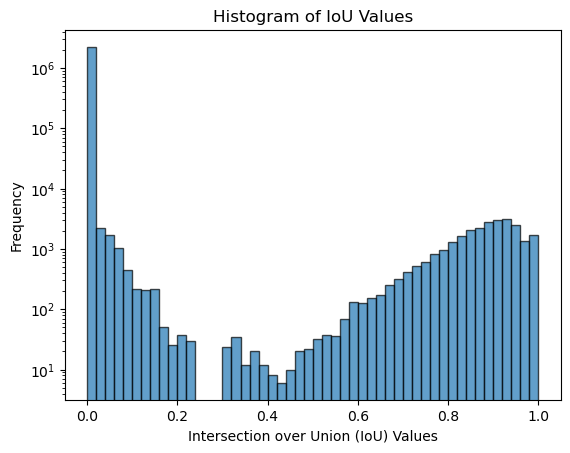

In [7]:
# Plot the distribution of IoU scores
data = iou_matrix.numpy().flatten()
fig, ax = plt.subplots()
ax.hist(data, bins=50, range=(0, 1), edgecolor='black', alpha=0.7, log=True)
ax.set_xlabel('Intersection over Union (IoU) Values')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of IoU Values')
fig.show()

# Clustering the bounding boxes

Having recorded all bounding boxes, we need to cluster them.
There are currently 2 approaches for that: clustering the graph directly, or transferring the graph into some embedding space and performing clustering there.

# Approach 1

In this case, we attempt to cluster the nodes of the graph directly, by applying the technique called "Spectral Clustering".

In [8]:
def spectral_clustering(adjacency_matrix, num_clusters):
    # Step 1: Create the Laplacian Matrix
    # Calculate the normalized Laplacian
    sqrt_inv_degree_matrix = np.diag(1 / np.sqrt(np.sum(adjacency_matrix, axis=1))) # D^(-1/2)
    normalized_laplacian = np.eye(len(adjacency_matrix)) - np.dot(sqrt_inv_degree_matrix, np.dot(adjacency_matrix, sqrt_inv_degree_matrix))
    
    # Step 2: Eigenvalue Decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)
    
    # Step 3: Select the Number of Clusters
    # You can use various methods to determine the number of clusters, such as the 'elbow' method.
    # For simplicity, we'll use a fixed number of clusters.
    
    # Step 4: Cluster the Data
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    cluster_assignments = kmeans.fit_predict(eigenvectors[:, 1:num_clusters + 1])

    # Calculate the average loss (inertia) of KMeans clustering
    average_loss = kmeans.inertia_
    
    return cluster_assignments, average_loss

## Manually deduce the number of clusters

If you choose to manually deduce the number of clusters, you will inspect the loss curve of K-means clusters, and infer the optimal number of clusters.

100%|██████████| 31/31 [00:14<00:00,  2.08it/s]
/tmp/ipykernel_8331/4117448341.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


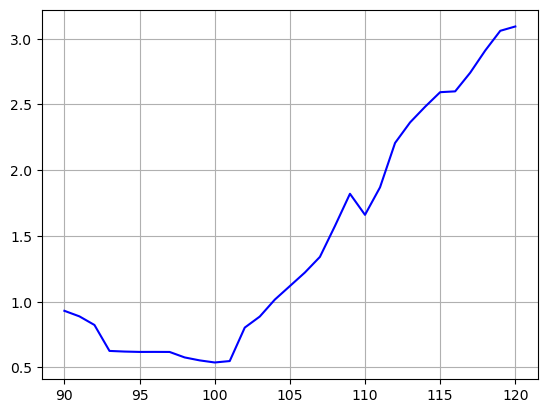

In [9]:
# Plot the K-means error plot
n_clusters_test_start = 90
n_clusters_test_end = 120
losses = {}

for n_clusters in tqdm(range(n_clusters_test_start, n_clusters_test_end + 1)):
    _, average_loss = spectral_clustering(adjacency_matrix, n_clusters)
    losses[n_clusters] = average_loss

# Plot the average loss depending on the number of clusters
fig, ax = plt.subplots()
ax.plot(losses.keys(), losses.values(), color='blue')
ax.grid(True)
fig.show()

In [10]:
n_clusters = 101
cluster_assignments, _ = spectral_clustering(adjacency_matrix, n_clusters)
print(f"Clustered the bounding boxes into {n_clusters} clusters.")
print(cluster_assignments)

Clustered the bounding boxes into 101 clusters.
[61 23 96 ... 67 71 98]


## Automatic inference of the number of cluster [not precise]

In this scenario, the number of clusters is approximated as the mean of detections per image.

In [23]:
n_clusters = int(n_boxes / len(anns_list))
print(f"Approximating the data as {n_clusters} clusters per image")
cluster_assignments, _ = spectral_clustering(adjacency_matrix, n_clusters)
print(f"Clustered the bounding boxes into {n_clusters} clusters.")
print(cluster_assignments)

Approximating the data as 105 clusters per image
Clustered the bounding boxes into 105 clusters.
[ 51  19  86  92  55  52  95  75   3  13  36  30  35   4  37 100   1  61
  57  10  22  42  90  58  25  49  89  81  16  54  39 101  88   2   4  26
  83  43  47   0  72 102  27   7  32  56  44  77  50  91  97  70  60  71
  23  29  73   4  48  94  15  93  96  53   5  99  18   8  66  20  40  59
   6  78  69  79  76  14  41  33  84  98  87  68  12  74  34  46  45  67
   9  24  11  82 103  63 104  80  31  21  28  65  62  38  64  85  17  51
   4  61  72  19  86  29  55 101  90  49  36  20  75  22   1  30  57   0
   4  81  42  13  47  52  25  10  35  98  88  56   7  54  92  32  97  91
  58   2  89  79   3  16  74  71  84  73  26  67  40  96 102  95  23  18
   5  33  99  44  70  78  94  14  39  50 100  68  83  87  27  34  53  45
  69  60 104  93   8  24  46  43  66  41  48  37  12  59  76 103  11  80
   9  31  64  38  28  21  82   6  15  65  63  77  62  85  20  19  42  86
  55  22  30  36   4  25  5

# Approach 2 (NOT FINISHED)

In this case we attempt to turn the nodes into embeddings, and perform clustering in the embedding space.

In [11]:
# Build a graph

import networkx as nx
from node2vec import Node2Vec

# Create an undirected weighted graph
G = nx.Graph()

# Add nodes and edges
print(f"Building a graph with {n_boxes} nodes")
for i in tqdm(range(n_boxes)):
    # Add the node
    G.add_node(i)

    # Add the edges
    for j in range(i + 1, n_boxes):
        dist = iou_matrix[i][j]
        if dist > 0:
            G.add_edge(i, j, weight=dist)


Building a graph with 4 nodes


100%|██████████| 4/4 [00:00<00:00, 148.38it/s]


In [12]:
# Convert the graph into the embeddings space

# Initialize and fit Node2Vec
print("Initializing the node-to-vector object")
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=12)

# Learn embeddings
print("Fitting the nodes")
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Initializing the node-to-vector object


Generating walks (CPU: 12): 100%|██████████| 16/16 [00:00<00:00, 1531.08it/s]


Fitting the nodes


In [13]:
# Get the embeddings
node_embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

for i in tqdm(range(n_boxes)):
    for j in range(i + 1, n_boxes):
            # IoU distance
            iou_dist = iou_matrix[i][j]
            
            # if iou_dist != 0 and iou_dist != 1:
            # Embedding distance
            emb_i = node_embeddings[str(i)]
            emb_j = node_embeddings[str(j)]
            emb_dist = emb_i - emb_j
            emb_dist = np.linalg.norm(emb_dist, ord=2)

            print(iou_dist, emb_dist)

NameError: name 'G' is not defined

# Visualizing clustered bounding boxes

After we have assigned bounding boxes to different clusters, we can visualize them.

In [11]:
from pprint import pprint

# Label the bounding boxes with different colors
sns.set_palette(palette='deep', n_colors=n_clusters)
colors = sns.color_palette() # Create a list of RGB colors, where each color corresponds to a cluster
assert len(bbox_list) == len(cluster_assignments) == n_boxes
for idx in range(n_boxes):
    bbox_list[idx]['cluster'] = cluster_assignments[idx]
    bbox_list[idx]['color'] = colors[cluster_assignments[idx]]
print(f"Labeled {n_boxes} bounding boxes")
pprint(bbox_list[:3])

Labeled 1505 bounding boxes
[{'annotations_file': 'data/slices/half/all_slices2_done_predictions/annotations/0.json',
  'cluster': 61,
  'color': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
  'x1': 381.6181640625,
  'x2': 442.67279052734375,
  'y1': 109.46029663085938,
  'y2': 152.11788940429688,
  'z': 0.0},
 {'annotations_file': 'data/slices/half/all_slices2_done_predictions/annotations/0.json',
  'cluster': 23,
  'color': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
  'x1': 12.88899040222168,
  'x2': 59.20838928222656,
  'y1': 703.7647705078125,
  'y2': 747.767333984375,
  'z': 0.0},
 {'annotations_file': 'data/slices/half/all_slices2_done_predictions/annotations/0.json',
  'cluster': 96,
  'color': (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
  'x1': 272.9186706542969,
  'x2': 339.9846496582031,
  'y1': 471.9687194824219,
  'y2': 524.7401123046875,
  'z': 0.0}]


In [12]:
# Visualize the bounding boxes per image
n_images = len(images_list)
save_dir = os.path.join(output_dir, "BoxesPerImage")
os.makedirs(save_dir, exist_ok=True)
print("Loading images and visualizing the clusters")
for idx, image_path in enumerate(images_list):
    # Fetch image information
    z = image_path.split('/')[-1].split('.')[0]
    bboxes = []
    anns_path = os.path.join(anns_dir, f"{z}.json")
    assert os.path.exists(anns_path)

    # Collect all the corresponding bounding boxes
    for bbox_info in bbox_list:
        if bbox_info['annotations_file'] == anns_path:
            bboxes.append(bbox_info)
    print(f"[{idx + 1}/{n_images}] Collected {len(bboxes)} bounding boxes for image {image_path}")

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Draw the bounding boxes with the corresponding colors
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        x1 = bbox['x1']
        y1 = bbox['y1']
        x2 = bbox['x2']
        y2 = bbox['y2']
        outline_color = tuple([int(x * 255) for x in bbox['color']])
        draw.rectangle([min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)], outline=outline_color)
    
    # Save the labeled image
    save_path = os.path.join(output_dir, "BoxesPerImage", image_path.split('/')[-1])
    image.save(save_path)

Loading images and visualizing the clusters
[1/21] Collected 63 bounding boxes for image data/slices/half/all_slices2_done_predictions/0.png
[2/21] Collected 58 bounding boxes for image data/slices/half/all_slices2_done_predictions/1.png
[3/21] Collected 82 bounding boxes for image data/slices/half/all_slices2_done_predictions/10.png
[4/21] Collected 81 bounding boxes for image data/slices/half/all_slices2_done_predictions/11.png
[5/21] Collected 80 bounding boxes for image data/slices/half/all_slices2_done_predictions/12.png
[6/21] Collected 76 bounding boxes for image data/slices/half/all_slices2_done_predictions/13.png
[7/21] Collected 75 bounding boxes for image data/slices/half/all_slices2_done_predictions/14.png
[8/21] Collected 72 bounding boxes for image data/slices/half/all_slices2_done_predictions/15.png
[9/21] Collected 75 bounding boxes for image data/slices/half/all_slices2_done_predictions/16.png
[10/21] Collected 71 bounding boxes for image data/slices/half/all_slices2_d

In [17]:
# Visualize the bounding boxes per cluster
save_dir = os.path.join(output_dir, "BoxesPerCluster")
os.makedirs(save_dir, exist_ok=True)
for cluster_idx in tqdm(range(n_clusters)):
    os.makedirs(os.path.join(save_dir, str(cluster_idx)), exist_ok=True)
    for idx, image_path in enumerate(images_list):
        # Fetch image information
        z = image_path.split('/')[-1].split('.')[0]
        bboxes = []
        anns_path = os.path.join(anns_dir, f"{z}.json")
        assert os.path.exists(anns_path)

        # Collect all the corresponding bounding boxes
        for bbox_info in bbox_list:
            if bbox_info['annotations_file'] == anns_path and bbox_info['cluster'] == cluster_idx:
                bboxes.append(bbox_info)

        # Load the image
        image = Image.open(image_path).convert('RGB')

        # Draw the bounding boxes with the corresponding colors
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:
            x1 = bbox['x1']
            y1 = bbox['y1']
            x2 = bbox['x2']
            y2 = bbox['y2']
            outline_color = tuple([int(x * 255) for x in bbox['color']])
            draw.rectangle([min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)], outline=outline_color)
        
        # Save the labeled image
        save_path = os.path.join(output_dir, "BoxesPerCluster", str(cluster_idx), image_path.split('/')[-1])
        image.save(save_path)

100%|██████████| 101/101 [06:52<00:00,  4.09s/it]


# Combine the 2D boxes into 3D frustums

In [13]:
# Function that retrieves all bounding boxes assigned to a particular cluster
def retrieve_cluster(bbox_list, idx):
    cluster = []
    for bbox_info in bbox_list:
        if bbox_info['cluster'] == idx:
            cluster.append(bbox_info)
    return cluster

# Function that converts a set of bounding boxes into 3D frustums. Return (xmin, xmax, ymin, ymax, zmin, zmax)
def bbox2frustum(cluster):
    # Extract bounding box coordinates (center, width, height)
    xmins = [min(bbox['x1'], bbox['x2']) for bbox in cluster]
    xmaxs = [max(bbox['x1'], bbox['x2']) for bbox in cluster]
    ymins = [min(bbox['y1'], bbox['y2']) for bbox in cluster]
    ymaxs = [max(bbox['y1'], bbox['y2']) for bbox in cluster]
    zs = [bbox['z'] for bbox in cluster]
    
    # Define the frustum
    x1 = min(xmins)
    y1 = min(ymins)
    x2 = max(xmaxs)
    y2 = max(ymaxs)
    z1 = min(zs)
    z2 = max(zs)

    frustum = {
        "x1": x1,
        "x2": x2,
        "y1": y1,
        "y2": y2,
        "z1": z1,
        "z2": z2,
    }

    return frustum

# Function that post-processes frustums
def postprocess_frustums(frustums_list):
    return frustums_list

# For each cluster idx, retrieve its bounding boxes and compute the 3D frustum
frustums_list = []
print(f"Retrieving {n_clusters} 3D frustums")
for idx in tqdm(range(n_clusters)):
    # Retrieve the cluster
    cluster = retrieve_cluster(bbox_list, idx)
    
    # Deduce the frustum
    frustum = bbox2frustum(cluster)
    frustum['cluster'] = idx

    # Append to the list of frustums
    frustums_list.append(frustum)

# Post-process frustums (e.g. remove outliers)
frustums_list = postprocess_frustums(frustums_list)

print("Frustums have been computed!")

Retrieving 101 3D frustums


100%|██████████| 101/101 [00:00<00:00, 385.16it/s]

Frustums have been computed!


# Visualize and save the frustums

In [15]:
save_dir = os.path.join(output_dir, "FrustumsPerCluster")
os.makedirs(save_dir, exist_ok=True)

# Save the frustums
with open(os.path.join(save_dir, "frustums_list.json"), 'w') as f:
    json.dump(frustums_list, f)

# Visualize the frustums per cluster
for cluster_idx in tqdm(range(n_clusters)):
    os.makedirs(os.path.join(save_dir, str(cluster_idx)), exist_ok=True)
    for idx, image_path in enumerate(images_list):
        # Fetch image information
        z = image_path.split('/')[-1].split('.')[0]
        bboxes = []
        anns_path = os.path.join(anns_dir, f"{z}.json")
        assert os.path.exists(anns_path)

        # Collect all the corresponding bounding boxes
        for bbox_info in frustums_list:
            if bbox_info['cluster'] == cluster_idx:
                bboxes.append(bbox_info)

        # Load the image
        image = Image.open(image_path).convert('RGB')
        
        # Draw the bounding boxes with the corresponding colors
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:
            x1 = bbox['x1']
            y1 = bbox['y1']
            x2 = bbox['x2']
            y2 = bbox['y2']
            z1 = bbox['z1']
            z2 = bbox['z2']
            if z1 <= float(z) <= z2:
                outline_color = tuple([int(x * 255) for x in colors[cluster_idx]])
                draw.rectangle([min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)], outline=outline_color)
        
        # Save the labeled image
        save_path = os.path.join(output_dir, "FrustumsPerCluster", str(cluster_idx), image_path.split('/')[-1])
        image.save(save_path)

100%|██████████| 101/101 [06:30<00:00,  3.86s/it]
